# Experiment: Kernel Weight Optimization
In this experiment, we investigate the effectiveness of combining multiple kernels in a Gaussian Process (GP) model for predicting search volume trends across three groups: Soccer (D1), Political (D2), and Tech (D3). The focus is on optimizing kernel weights to determine which kernels contribute most significantly to the predictive performance.

## Procedure
Combine Squared-Exponential (SE) kernel, Linear kernel, Matern kernel, Sinusoidal kernel, and Spectral Mixture kernel (10 mixture components). Our training data consists of the first 765 days of data and testing period is the last 68 days of data. The input will be a specific day and the corresponding search fvoluem for all groups, excluding the output group. 

In [6]:
import numpy as onp
import matplotlib.pyplot as plt

from sparse_gp import *
from plots import *
from data import *

prng_key = random.key(0)

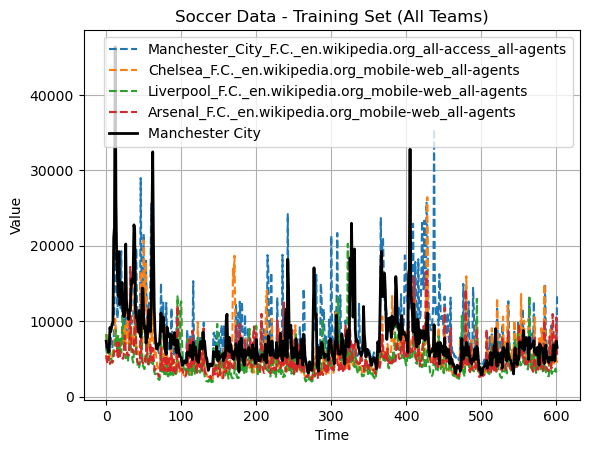

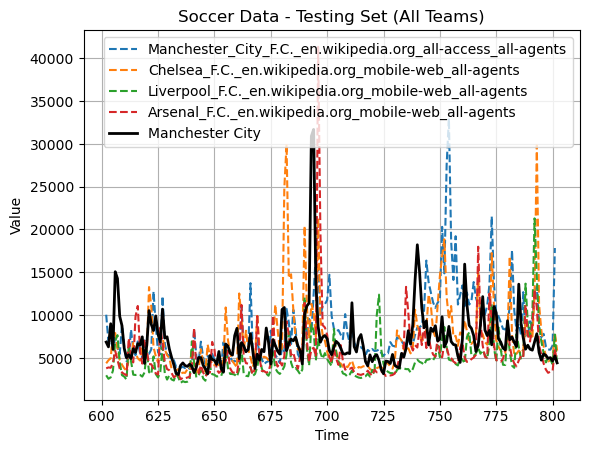

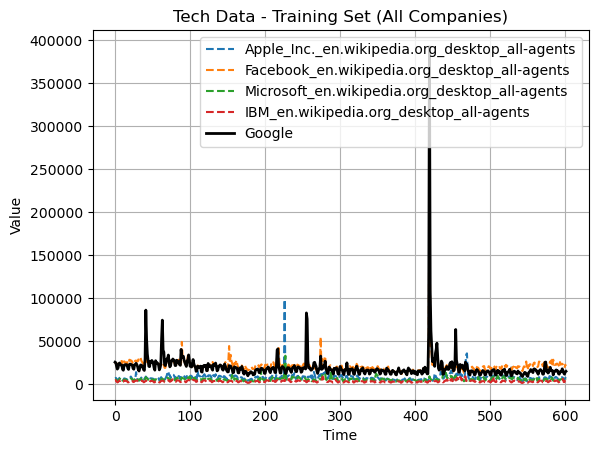

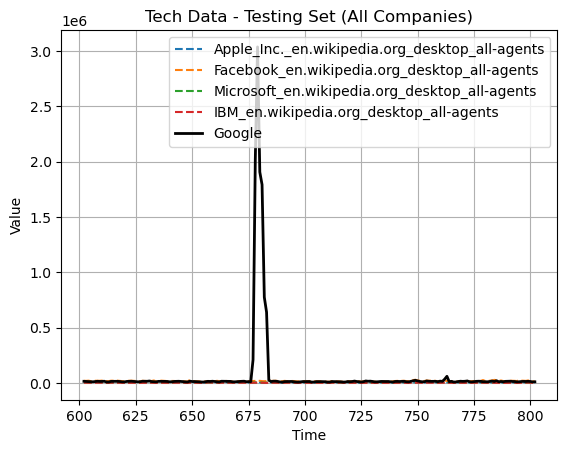

In [8]:
# Load datasets
all_data = load_all()
tech = load_tech()
politics = load_politics()
soccer = load_soccer()

# Example: Split Soccer data into training and testing sets
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = split_train_test_matrix(soccer, train_ratio=0.75, target_column=0)

# Generate integer day labels
time_train = np.arange(X_train_soccer.shape[0])  # Days for training set
time_test = np.arange(X_train_soccer.shape[0], X_train_soccer.shape[0] + X_test_soccer.shape[0])  # Days for testing set

# Soccer group feature names (e.g., team names)
soccer_feature_names = [row[0] for row in soccer if row[0] != soccer[0, 0]]

# Plot all soccer teams in the training set
plot_time_series(
    X=X_train_soccer, 
    Y=y_train_soccer, 
    time=time_train, 
    feature_names=soccer_feature_names, 
    target_name="Manchester City",  # Example target
    title="Soccer Data - Training Set (All Teams)"
)

# Plot all soccer teams in the testing set
plot_time_series(
    X=X_test_soccer, 
    Y=y_test_soccer, 
    time=time_test, 
    feature_names=soccer_feature_names, 
    target_name="Manchester City",  # Example target
    title="Soccer Data - Testing Set (All Teams)"
)

# Example: Repeat for Tech data
X_train_tech, X_test_tech, y_train_tech, y_test_tech = split_train_test_matrix(tech, train_ratio=0.75, target_column=0)

# Generate integer day labels for Tech
time_train_tech = np.arange(X_train_tech.shape[0])
time_test_tech = np.arange(X_train_tech.shape[0], X_train_tech.shape[0] + X_test_tech.shape[0])

# Tech group feature names (e.g., companies)
tech_feature_names = [row[0] for row in tech if row[0] != tech[0, 0]]

# Plot all tech companies in the training set
plot_time_series(
    X=X_train_tech, 
    Y=y_train_tech, 
    time=time_train_tech, 
    feature_names=tech_feature_names, 
    target_name="Google",  # Example target
    title="Tech Data - Training Set (All Companies)"
)

# Plot all tech companies in the testing set
plot_time_series(
    X=X_test_tech, 
    Y=y_test_tech, 
    time=time_test_tech, 
    feature_names=tech_feature_names, 
    target_name="Google",  # Example target
    title="Tech Data - Testing Set (All Companies)"
)


# Soccer Data
Test on soccer data with 100 inducing points.

## Parameter Initialization

In [ ]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams():
    # Three initial weights in log space for unconstrained optimization
    initial_weights = [np.log(0.33), np.log(0.33), np.log(0.33)]
    
    # Initial hyperparameters for each kernel
    hyperparams_sqexp = [0.1, 1.0, 10.0]        # [noise_variance, signal_variance, length_scale]
    hyperparams_linear = [0.1, 1.0]             # [noise_variance, signal_variance]
    hyperparams_matern = [0.1, 1.0, 10.0, 2.5]  # [noise_variance, signal_variance, length_scale, nu]

    # Concatenate all hyperparameters
    initial_params = initial_weights + hyperparams_sqexp + hyperparams_linear + hyperparams_matern
    return np.array(initial_params)
#

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [ ]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

In [ ]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 3 Weights:", np.sum(optimized_hyperparams[:3]))

## Predict and Plot the Results

In [ ]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [ ]:
# Extract weights
weights = optimized_hyperparams[:3]
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Nu: {optimized_hyperparams[11]:.4f}")

## NLPD on Test Data

In [ ]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

## ELBO Maximization

In [ ]:
plot_elbo(history)

## Kernel Hyperparameters

In [ ]:
plot_kernel_hyperparameters(history)

# Test Experiment 2
Test on 100 inducing points.

## Parameter Initialization

In [ ]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=100)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [ ]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 500

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo, history = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

In [ ]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of First 2 Weights:", np.sum(optimized_hyperparams[:2]))

## Predict and Plot the Results

In [ ]:
plot_sparse_gp_with_uncertainty(X_train, Y_train, X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive)

In [ ]:
# Extract weights
weights = optimized_hyperparams[:3]
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")
print(f"Kernel 3 (Matérn): {weight_percentages[2]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[6]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[7]:.4f}")
print(f"Kernel 3 - Noise Variance: {optimized_hyperparams[8]:.4f}")
print(f"Kernel 3 - Signal Variance: {optimized_hyperparams[9]:.4f}")
print(f"Kernel 3 - Length Scale: {optimized_hyperparams[10]:.4f}")
print(f"Kernel 3 - Nu: {optimized_hyperparams[11]:.4f}")

## NLPD

In [ ]:
train_nlpd = calculate_nlpd(X_train, Y_train, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])
test_nlpd = calculate_nlpd(X_test, Y_test, Z, optimized_hyperparams, sparse_gp_posterior_predictive, noise_variance=optimized_hyperparams[2])

print(f"Train NLPD: {train_nlpd:.4f}")
print(f"Test NLPD: {test_nlpd:.4f}")

## ELBO Maximization


In [ ]:
plot_elbo(history)

## Kernel Hyperparameters

In [ ]:
plot_kernel_hyperparameters(history)